# MESCAL 101: StudyManager and Dataset Fundamentals

## Introduction

This notebook demonstrates the core functionality of MESCAL's StudyManager - the central component for handling multiple scenarios and scenario comparisons in energy system modeling studies. It showcases how MESCAL's architecture simplifies working with complex multi-scenario analyses through a consistent and powerful interface.

Rather than juggling separate data structures for each scenario, MESCAL provides a unified framework where:
- Every data element is accessible through a consistent API
- Scenarios and comparisons are handled through the same paradigm
- Data relationships are automatically preserved and utilized

We'll use PyPSA's Scigrid DE example dataset for this demonstration, but the same principles apply regardless of which modeling platform you use.


## Setup

In [1]:
# Setting up Notebook environment (set working directory, add path, ensure submodule inclusion)
# No need to read ;)

def setup_notebook_env():
    """Locate repository root, set working directory, and include submodules."""
    import os
    import sys
    from pathlib import Path

    def find_repo_root():
        current = Path(os.getcwd()).absolute()
        while current != current.parent:
            if (current / '.git').exists() or (current / 'submodules').exists():
                return current
            current = current.parent
        raise FileNotFoundError(f"Could not find repository root starting from {os.getcwd()}.")

    repo_root = find_repo_root()
    os.chdir(repo_root) # Change working directory

    # Add to path
    if str(repo_root) not in sys.path:
        sys.path.insert(0, str(repo_root))
        
    # Ensure all submodules are included in the path
    from vanilla.notebook_config import add_submodules_to_path    
    add_submodules_to_path()
    
    
setup_notebook_env()

In [2]:
import os
from IPython.display import Image
import pypsa

from mescal import StudyManager
from mescal.utils.plotly_utils.plotly_theme import PlotlyTheme
from mescal_pypsa import PyPSADataset
from vanilla.notebook_config import configure_clean_output_for_jupyter_notebook

configure_clean_output_for_jupyter_notebook()
PlotlyTheme().apply()

In [3]:
# Register study-specific interpreters (details on this will be covered in a later notebook)
from studies.study_01_intro_to_mescal.src.study_specific_model_interpreters import ControlAreaModelInterpreter, ScigridDEBusModelInterpreter

PyPSADataset.register_interpreter(ControlAreaModelInterpreter)
PyPSADataset.register_interpreter(ScigridDEBusModelInterpreter);

## Loading Example Data

For this demonstration, we use a PyPSA Scigrid DE example with a base network and four scenarios with increased solar and wind capacity. All networks have already been optimized.

In [4]:
# Loading networks (all have already been optimized, so the results are included)
study_folder = 'studies/study_01_intro_to_mescal'
networks_folder = os.path.join(study_folder, 'data/networks_scigrid_de')

n_base = pypsa.Network(os.path.join(networks_folder, 'base.nc'))
n_solar_150 = pypsa.Network(os.path.join(networks_folder, 'solar_150.nc'))
n_solar_200 = pypsa.Network(os.path.join(networks_folder, 'solar_200.nc'))
n_wind_150 = pypsa.Network(os.path.join(networks_folder, 'wind_150.nc'))
n_wind_200 = pypsa.Network(os.path.join(networks_folder, 'wind_200.nc'))

## The StudyManager

The StudyManager is the central component of MESCAL, organizing all scenarios and scenario comparisons for efficient access and analysis.

In [5]:
study = StudyManager.factory_from_scenarios(
    scenarios=[
        PyPSADataset(n_base,        name='base'),
        PyPSADataset(n_solar_150,   name='solar_150'),
        PyPSADataset(n_solar_200,   name='solar_200'),
        PyPSADataset(n_wind_150,    name='wind_150'),
        PyPSADataset(n_wind_200,    name='wind_200'),
    ],
    comparisons=[('solar_150', 'base'), ('solar_200', 'base'), ('wind_150', 'base'), ('wind_200', 'base')],
    export_folder=os.path.join(study_folder, 'non_versioned/output'),
)

In just a few lines of code, we've organized all scenarios and defined which comparisons we're interested in (here, comparing each scenario to the base case).

## The Dataset Concept

The core building block in MESCAL is the Dataset class. The key insight is that:

### Everything is a Dataset!

- Individual scenarios are Datasets
- Collections of scenarios are Datasets
- Scenario comparisons are Datasets
- Collections of comparisons are Datasets

This means you interact with all entities through a consistent interface, regardless of whether you're working with a single scenario or a complex collection of scenario comparisons.

## Working with Datasets

Let's explore the fundamental operations with Datasets:

### Accessing a Single Dataset

In [6]:
ds_base = study.scen.get_dataset('base')

### Fetching Data 

The primary method for interacting with Datasets is the `fetch()` method:

In [7]:
df_price_base = ds_base.fetch('buses_t.marginal_price')
print(df_price_base.head())

Bus                     1    10    100  ...    98     99  99_220kV
snapshot                                ...                       
2011-01-01 00:00:00 -0.44  5.77  23.12  ...  1.89  23.72     23.69
2011-01-01 01:00:00 -0.58  6.10  22.53  ...  1.96  23.19     23.14
2011-01-01 02:00:00 -0.58  6.07  22.11  ...  1.95  22.75     22.71
2011-01-01 03:00:00 -0.60  6.14  21.50  ...  2.00  22.12     22.08
2011-01-01 04:00:00 -0.61  6.16  20.39  ...  2.03  20.98     20.94

[5 rows x 585 columns]


For PyPSA users, note that this produces the same output as `n_base.buses_t.marginal_price` but provides a consistent interface across all platforms.

### Discovering Available Data

To see what data is available in a Dataset:

In [8]:
accepted_flags = ds_base.accepted_flags
list(sorted(accepted_flags))[:15]  # Just showing the first 15

['buses',
 'buses_t.marginal_price',
 'buses_t.p',
 'buses_t.q',
 'buses_t.v_ang',
 'buses_t.v_mag_pu',
 'buses_t.v_mag_pu_set',
 'carriers',
 'control_areas',
 'generators',
 'generators_t.efficiency',
 'generators_t.marginal_cost',
 'generators_t.marginal_cost_quadratic',
 'generators_t.mu_lower',
 'generators_t.mu_p_set']

Or to find specific types of data:

In [9]:
accepted_flags_for_lines = ds_base.get_accepted_flags_containing_x('lines')
accepted_flags_for_lines

{'lines',
 'lines_t.mu_lower',
 'lines_t.mu_upper',
 'lines_t.p0',
 'lines_t.p1',
 'lines_t.q0',
 'lines_t.q1',
 'lines_t.s_max_pu'}

## From Simple to Powerful: Scenario Collections

While the individual Dataset interface is useful, MESCAL's true power emerges when working with multiple scenarios.

Let's fetch the marginal price data for all scenarios at once:

In [10]:
df_price = study.scen.fetch('buses_t.marginal_price')
print(df_price.head())

dataset              base               ... wind_200                
Bus                     1    10    100  ...       98     99 99_220kV
snapshot                                ...                         
2011-01-01 00:00:00 -0.44  5.77  23.12  ...     0.07  23.83    23.79
2011-01-01 01:00:00 -0.58  6.10  22.53  ...    -0.06  22.38    22.33
2011-01-01 02:00:00 -0.58  6.07  22.11  ...    -0.05  20.49    20.44
2011-01-01 03:00:00 -0.60  6.14  21.50  ...    -0.15  18.64    18.60
2011-01-01 04:00:00 -0.61  6.16  20.39  ...    -0.12  15.92    15.89

[5 rows x 2925 columns]


The result is a MultiIndex DataFrame with an additional 'dataset' level containing all scenario data in a single structure.

## Scenario Comparisons

Similarly, we can get comparison data (deltas between scenarios):


In [11]:
df_price_change = study.comp.fetch('buses_t.marginal_price')
print(df_price_change.head())

dataset             solar_150 vs base                  ... wind_200 vs base               
Bus                                 1    10       100  ...               98    99 99_220kV
snapshot                                               ...                                
2011-01-01 00:00:00          2.09e-01  0.02  2.10e-02  ...            -1.82  0.10     0.11
2011-01-01 01:00:00          1.80e-02  0.06 -8.06e-02  ...            -2.02 -0.81    -0.82
2011-01-01 02:00:00          1.32e-02  0.08 -2.84e-03  ...            -2.01 -2.26    -2.26
2011-01-01 03:00:00          2.69e-02  0.01 -1.57e-01  ...            -2.15 -3.48    -3.48
2011-01-01 04:00:00          8.89e-04 -0.12 -8.88e-01  ...            -2.15 -5.06    -5.05

[5 rows x 2340 columns]


Each column in this DataFrame represents the difference between a variation scenario and the base scenario.

## Visualization Example

Now let's see this in action with a visualization. We'll create a unified analysis of average generation by carrier, control area, and scenario:


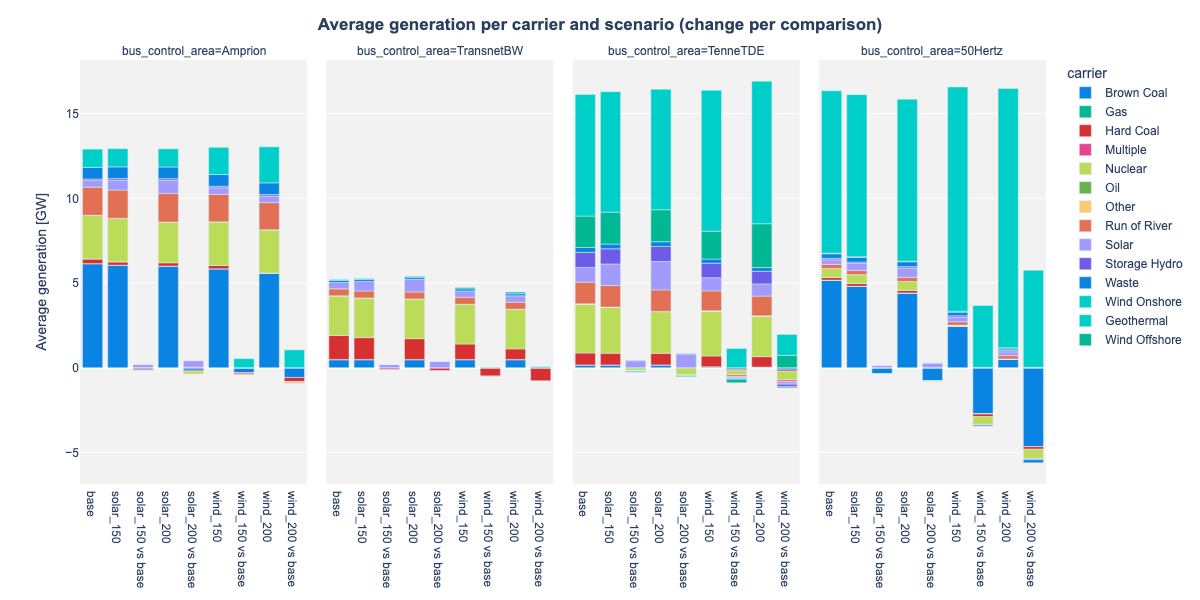

In [12]:
import plotly.express as px
from mescal.utils.pandas_utils import flatten_df, prepend_model_prop_levels, filter_by_model_query

generators_model_df = study.scen.get_dataset('base').fetch('generators')
data = study.scen_comp.fetch('generators_t.p')
data = prepend_model_prop_levels(data, generators_model_df, 'bus_control_area', 'carrier')
data = data.mean().groupby(level=['dataset', 'bus_control_area', 'carrier']).sum()
data = data / 1e3  # MW to GW
data_flat = data.to_frame('value').reset_index()
fig = px.bar(
    data_frame=data_flat,
    y='value',
    x='dataset',
    facet_col='bus_control_area',
    color='carrier',
    category_orders={'bus_control_area': ['Amprion', 'TransnetBW', 'TenneTDE', '50Hertz']},
    labels={'value': 'Average generation [GW]'},
)
fig.update_layout(title='<b>Average generation per carrier and scenario (change per comparison)</b>', width=1200)
fig.update_xaxes(title=None)

# Save and display the image
image_path = study.export_path('generation_barchart.png')
fig.update_layout(height=600, width=1200)
fig.write_image(image_path)
Image(image_path)

# fig.show()  # Use this instead when you are running locally and want to have full interactivity in the plot

## Key Takeaways

- **Unified Interface**: Whether working with individual scenarios or complex collections, the same methods apply
- **Efficient Analysis**: Analyze multiple scenarios with the same code you'd use for one
- **Automatic Comparison**: Calculate scenario deltas without manual calculations
- **Hierarchical Organization**: Study → Scenarios → Individual Datasets provides a logical structure
- **Consistency Across Platforms**: The same code works regardless of your modeling platform

In the next notebook, we'll explore more advanced data fetching and transformation techniques that build on these fundamentals.
